# GSE161529 Cross Validation Notebook

## Table of Contents
1. [Introduction](#introduction)
2. [Imports](#imports)
3. [Path for Assets](#path-for-assets)
4. [Data Loading](#data-loading)

## Introduction

Cross validation of GSE161529 dataset using saved model from GSE176078

## Imports

In [1]:
# Necessary imports for the notebook. Please ensure these libraries are installed in your Python environment, 
# if not then please install them using the requirements.txt file.
import pandas as pd
import joblib
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import joblib
import shap

a:\Capstone Local-GIt\ghost-cell-busters\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Path for Assets

In [2]:
# This is the relative path of the assets directory, if the assets are in another location please change the path accordingly.
assets = "../assets"

# Data Loading

In [3]:
# Load trained model
model_path = f"{assets}/GSE176078/GSE176078_xgboost_model.pkl"
xgb_model = joblib.load(model_path)

In [ ]:
df = pd.read_csv(f"{assets}/GSE161529/GSE161529_obs.csv")

In [ ]:
features = xgb_model.feature_names_in_.tolist()
features

['apoptosis_score',
 'oxphos_score',
 'pct_counts_ribo',
 'nCount_RNA',
 'cnv_score',
 'proto_oncogenescore',
 'S_score',
 'G2M_score',
 'percent.mito']

In [ ]:
# Drop missing values and predict
df = df.dropna(subset=features)
X_val = df[features]
df["tumor_prob_mito"] = xgb_model.predict_proba(X_val)[:, 1]
df["tumor_pred_mito"] = (df["tumor_prob_mito"] > 0.5).astype(int)
df["tumor_pred_label_mito"] = df["tumor_pred_mito"].map({0: "Predicted Normal", 1: "Predicted Tumor"})

print("Predictions completed and stored in df.")


Predictions completed and stored in df_val_clean.


In [ ]:
df.head()

,Unnamed: 0,sample,sample_id,nCount_RNA,percent.mito,pct_counts_ribo,oxphos_score,apoptosis_score,S_score,G2M_score,phase,cnv_reference,cnv_score,proto_oncogenescore,tumor_prob_mito,tumor_pred_mito,tumor_pred_label_mito
0,AAACCTGAGACTAGGC-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,3587.0,0.0,34.011710,0.625094,-0.107095,-0.267442,-0.172494,G1,tumor,0.015120,0.1,0.997642,1,Predicted Tumor
1,AAACCTGAGGACAGAA-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,1003.0,0.0,41.375874,0.034769,-0.088353,-0.042636,-0.047786,G1,tumor,0.006566,0.1,0.692226,1,Predicted Tumor
2,AAACCTGAGGATGTAT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,7536.0,0.0,34.262207,0.494331,1.516734,-0.428295,-0.325175,G1,tumor,0.036739,1.4,0.969477,1,Predicted Tumor
3,AAACCTGCAAGAGGCT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,10366.0,0.0,27.532318,1.197279,-0.373494,-0.451550,-0.168998,G1,tumor,0.057310,0.7,0.996261,1,Predicted Tumor
4,AAACCTGGTAGCTTGT-1,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,1628.0,0.0,29.545454,-0.016629,0.073628,-0.058140,-0.006993,G1,tumor,0.008319,0.7,0.996349,1,Predicted Tumor


In [ ]:
# Group by predicted tumor class and compute mean
grouped_summary = df.groupby("tumor_pred_mito")[features].mean().T
grouped_summary.columns = ["Predicted Normal (0)", "Predicted Tumor (1)"]

# Print results
print("Mean Feature Values by Predicted Tumor Class:")
grouped_summary.round(4)

Mean Feature Values by Predicted Tumor Class:
                     Predicted Normal (0)  Predicted Tumor (1)
apoptosis_score                   -0.0434              -0.1103
oxphos_score                       0.1144               0.7777
pct_counts_ribo                   22.8732              23.4714
nCount_RNA                       801.0640            5533.7122
cnv_score                          0.0164               0.0340
proto_oncogenescore                0.0472               0.4808
S_score                           -0.0212              -0.2441
G2M_score                         -0.0300              -0.2021
percent.mito                       0.0000               0.0000


In [ ]:
# Create groups
group0 = df[df["tumor_pred_mito"] == 0]
group1 = df[df["tumor_pred_mito"] == 1]

# Run t-tests and collect results
results = []
for feature in features:
    t_stat, p_val = ttest_ind(group0[feature], group1[feature], equal_var=False)
    results.append({
        "feature": feature,
        "mean_group0": group0[feature].mean(),
        "mean_group1": group1[feature].mean(),
        "t_stat": t_stat,
        "p_value": p_val
    })

# Convert to DataFrame and sort by p-value
t_test_results = pd.DataFrame(results).sort_values("p_value")

# Display results
t_test_results

,feature,mean_group0,mean_group1,t_stat,p_value
0,apoptosis_score,-0.043439,-0.110290,52.818454,0.000000e+00
1,oxphos_score,0.114441,0.777726,-210.760236,0.000000e+00
3,nCount_RNA,801.064043,5533.712176,-235.163160,0.000000e+00
4,cnv_score,0.016416,0.034015,-284.824947,0.000000e+00
5,proto_oncogenescore,0.047189,0.480763,-226.180939,0.000000e+00
6,S_score,-0.021157,-0.244057,161.414440,0.000000e+00
7,G2M_score,-0.030005,-0.202130,105.387022,0.000000e+00
2,pct_counts_ribo,22.873194,23.471415,-7.702360,1.408513e-14
8,percent.mito,0.000000,0.000000,NaN,NaN


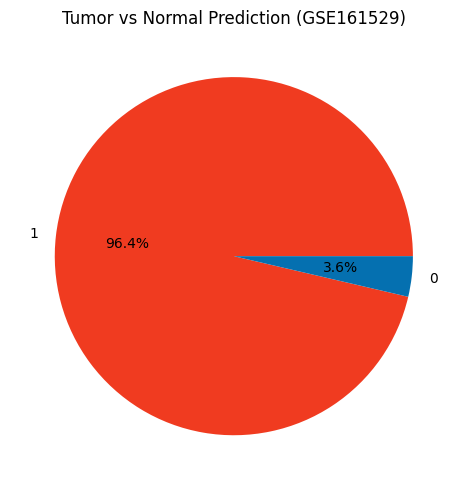

In [ ]:
df["tumor_pred_mito"].value_counts().plot.pie(
    autopct="%1.1f%%",
    colors=["#f03b20", "#0570b0"],
    figsize=(5, 5)
)
plt.title("Tumor vs Normal Prediction (GSE161529)")
plt.ylabel("")
plt.tight_layout()
plt.show()

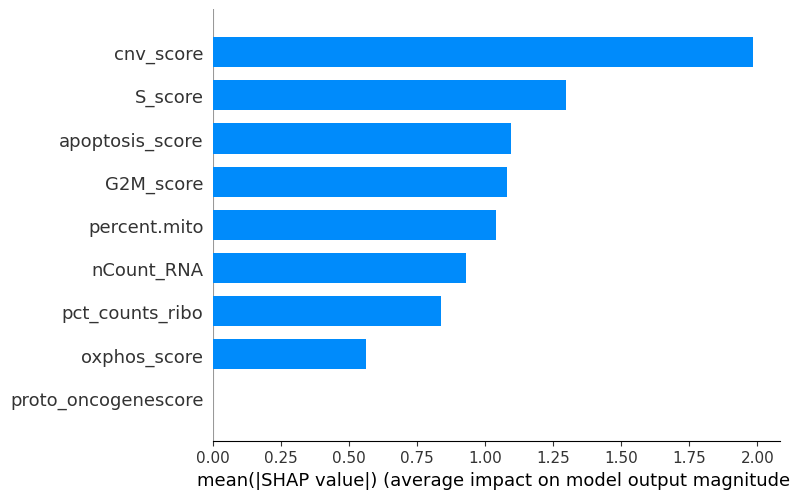

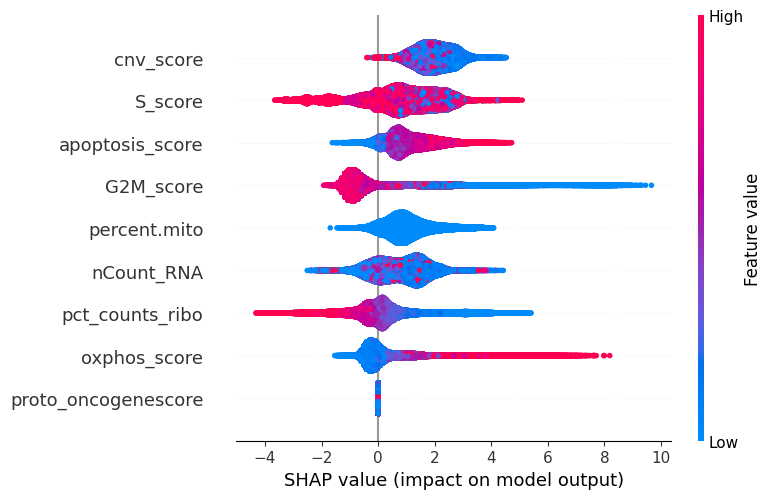

In [ ]:
# Use TreeExplainer instead of the default (which tries to load GPU deps)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_val)

# Bar summary plot
shap.summary_plot(shap_values, X_val, plot_type="bar")

# Beeswarm summary plot
shap.summary_plot(shap_values, X_val)

In [ ]:
# Saved this csv which will be used for oncogene analysis.
df.to_csv(f"{assets}/GSE161529/GSE161529_predictions.csv", index=True)